---
## ⚡ QUICK START: Upload and Predict Your Image

**Want to test immediately?** Follow these simple steps:

1. **Save your handwritten digit image** in this notebook's directory
2. **Update the filename** in the cell below
3. **Run the cell** to get your prediction!

---

In [52]:
# ================================================================
# 🎯 UPLOAD YOUR IMAGE HERE
# ================================================================
#
# INSTRUCTIONS:
# 1. Place your handwritten digit image (0-9) in this directory
# 2. Update the filename below (e.g., "my_digit.png", "test.jpg")
# 3. Set INVERT_COLORS:
#    - True: if your digit is BLACK on WHITE background (most common)
#    - False: if your digit is WHITE on BLACK background (like MNIST)
# 4. Run this cell!
#
# NOTE: This cell will work AFTER you complete the training below.
# ================================================================

# YOUR IMAGE FILENAME HERE:
IMAGE_FILENAME = "my_digit.png"  # Change this to your image filename

# Color setting:
INVERT_COLORS = True  # True for black digit on white background

# ================================================================

import os

# Check if image exists
if os.path.exists(IMAGE_FILENAME):
    print("✅ Image found!")
    print(f"📁 File: {IMAGE_FILENAME}")
    print("\n⚠️ Make sure you have trained the model first by running all cells below.")
    print("\n📌 After training, re-run this cell to see your prediction!")
    
    # Try to make prediction (will work after training)
    try:
        from PIL import Image
        import numpy as np
        
        # Display the uploaded image
        img = Image.open(IMAGE_FILENAME)
        import matplotlib.pyplot as plt
        plt.figure(figsize=(4, 4))
        plt.imshow(img, cmap='gray')
        plt.title("Your Uploaded Image", fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.show()
        
        # Try prediction if model is trained
        if 'trained_parameters' in dir():
            predicted_digit, confidence, probabilities, _, _ = predict_digit(
                IMAGE_FILENAME, 
                trained_parameters, 
                invert=INVERT_COLORS
            )
            
            print("\n" + "="*70)
            print(f"The uploaded handwritten digit is recognized as: {predicted_digit}")
            print("="*70)
            print(f"Confidence: {confidence*100:.2f}%")
            print("\nTop 3 predictions:")
            top_3 = np.argsort(probabilities)[-3:][::-1]
            for i, idx in enumerate(top_3, 1):
                print(f"  {i}. Digit {idx}: {probabilities[idx]*100:.2f}%")
            print("="*70)
            
            # Display with visualization
            display_prediction(IMAGE_FILENAME, trained_parameters, invert=INVERT_COLORS)
        else:
            print("\n⚠️ Model not trained yet. Please run all cells below to train the model first.")
            
    except NameError:
        print("\n⚠️ Prediction functions not loaded yet.")
        print("Please run all cells in this notebook first to:")
        print("  1. Define the prediction functions")
        print("  2. Train the neural network")
        print("  3. Then come back and re-run this cell")
    except Exception as e:
        print(f"\n❌ Error: {str(e)}")
        
else:
    print(f"❌ Image file '{IMAGE_FILENAME}' not found!")
    print("\n📋 To upload your image:")
    print("  1. Save your handwritten digit image (PNG, JPG, JPEG)")
    print("  2. Place it in this notebook's directory:")
    print(f"     {os.getcwd()}")
    print(f"  3. Update IMAGE_FILENAME variable above")
    print("  4. Run this cell again")
    print("\n💡 You can also drag-and-drop the image file into the file browser.")


❌ Image file 'my_digit.png' not found!

📋 To upload your image:
  1. Save your handwritten digit image (PNG, JPG, JPEG)
  2. Place it in this notebook's directory:
     /root/AI/Digit-recognition-from-scratch
  3. Update IMAGE_FILENAME variable above
  4. Run this cell again

💡 You can also drag-and-drop the image file into the file browser.


# Handwritten Digit Recognition from Scratch

**Built Without Deep Learning Libraries**

This notebook implements a complete neural network from scratch to recognize handwritten digits (0-9) from images. 

## Key Features:
- No TensorFlow, PyTorch, or Keras
- Pure algorithmic implementation using NumPy
- Detailed mathematical explanations
- Custom image input support
- Output format: "The uploaded handwritten digit is recognized as: X"

## Architecture:
- Input Layer: 784 neurons (28x28 pixels)
- Hidden Layer: 128 neurons (ReLU activation)
- Output Layer: 10 neurons (Softmax activation)
- Training: Backpropagation with mini-batch gradient descent

## 1. Import Required Libraries

We'll use only basic libraries:
- **NumPy**: For numerical operations and matrix computations
- **Matplotlib**: For visualization
- **PIL (Pillow)**: For image loading and preprocessing
- **urllib**: For downloading MNIST dataset
- **gzip**: For decompressing dataset files

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
import gzip
import os
import pickle

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
NumPy version: 2.4.2


## 2. Load and Preprocess the MNIST Dataset

The MNIST dataset contains 60,000 training images and 10,000 test images of handwritten digits.

### Process:
1. Download the dataset from the official source
2. Extract images and labels
3. Normalize pixel values from [0, 255] to [0, 1]
4. Flatten 28x28 images into 784-dimensional vectors
5. One-hot encode labels for classification

In [54]:
def download_mnist():
    """Download MNIST dataset from the internet with multiple mirror fallbacks"""
    
    # Multiple mirror URLs for reliability
    mirror_urls = [
        "https://github.com/fgnt/mnist/raw/master/",
        "http://yann.lecun.com/exdb/mnist/",
        "https://ossci-datasets.s3.amazonaws.com/mnist/",
    ]
    
    files = {
        "train_images": "train-images-idx3-ubyte.gz",
        "train_labels": "train-labels-idx1-ubyte.gz",
        "test_images": "t10k-images-idx3-ubyte.gz",
        "test_labels": "t10k-labels-idx1-ubyte.gz"
    }
    
    data_dir = "mnist_data"
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    for key, filename in files.items():
        filepath = os.path.join(data_dir, filename)
        if not os.path.exists(filepath):
            print(f"Downloading {filename}...")
            
            # Try each mirror until one succeeds
            downloaded = False
            for mirror_url in mirror_urls:
                try:
                    full_url = mirror_url + filename
                    print(f"  Trying: {mirror_url}...")
                    urllib.request.urlretrieve(full_url, filepath)
                    print(f"  ✓ Downloaded {filename}")
                    downloaded = True
                    break
                except Exception as e:
                    print(f"  ✗ Failed: {type(e).__name__}")
                    continue
            
            if not downloaded:
                print(f"\n{'='*70}")
                print(f"❌ ERROR: Could not download {filename} from any mirror")
                print(f"{'='*70}")
                print(f"\n🔧 MANUAL DOWNLOAD INSTRUCTIONS:")
                print(f"\n1. Visit one of these URLs in your browser:")
                for mirror in mirror_urls:
                    print(f"   {mirror}{filename}")
                print(f"\n2. Save the file to: {os.path.abspath(filepath)}")
                print(f"\n3. Re-run this cell after downloading all 4 files")
                print(f"{'='*70}\n")
                raise Exception(f"Failed to download {filename}. Please download manually.")
        else:
            print(f"✓ {filename} already exists")
    
    return data_dir

def load_mnist_images(filepath):
    """Load MNIST images from compressed file"""
    with gzip.open(filepath, 'rb') as f:
        # Read header information
        magic = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        rows = int.from_bytes(f.read(4), 'big')
        cols = int.from_bytes(f.read(4), 'big')
        
        # Read image data
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape(num_images, rows, cols)
    
    return data

def load_mnist_labels(filepath):
    """Load MNIST labels from compressed file"""
    with gzip.open(filepath, 'rb') as f:
        # Read header information
        magic = int.from_bytes(f.read(4), 'big')
        num_labels = int.from_bytes(f.read(4), 'big')
        
        # Read label data
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    
    return labels

def preprocess_data(images, labels):
    """
    Preprocess images and labels for neural network
    
    Steps:
    1. Flatten 28x28 images to 784-dimensional vectors
    2. Normalize pixel values from [0, 255] to [0, 1]
    3. One-hot encode labels
    """
    # Flatten images: (num_samples, 28, 28) -> (num_samples, 784)
    X = images.reshape(images.shape[0], -1)
    
    # Normalize pixel values to [0, 1]
    X = X.astype(np.float32) / 255.0
    
    # One-hot encode labels
    # Example: label 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    num_classes = 10
    Y = np.zeros((labels.shape[0], num_classes))
    Y[np.arange(labels.shape[0]), labels] = 1
    
    return X, Y

# Download and load the dataset
print("=" * 60)
print("LOADING MNIST DATASET")
print("=" * 60)

data_dir = download_mnist()

# Load training data
train_images = load_mnist_images(os.path.join(data_dir, "train-images-idx3-ubyte.gz"))
train_labels = load_mnist_labels(os.path.join(data_dir, "train-labels-idx1-ubyte.gz"))

# Load test data
test_images = load_mnist_images(os.path.join(data_dir, "t10k-images-idx3-ubyte.gz"))
test_labels = load_mnist_labels(os.path.join(data_dir, "t10k-labels-idx1-ubyte.gz"))

print(f"\nRaw Data Shapes:")
print(f"Training images: {train_images.shape}")
print(f"Training labels: {train_labels.shape}")
print(f"Test images: {test_images.shape}")
print(f"Test labels: {test_labels.shape}")

# Preprocess the data
X_train, Y_train = preprocess_data(train_images, train_labels)
X_test, Y_test = preprocess_data(test_images, test_labels)

print(f"\nPreprocessed Data Shapes:")
print(f"X_train: {X_train.shape} (flattened and normalized)")
print(f"Y_train: {Y_train.shape} (one-hot encoded)")
print(f"X_test: {X_test.shape}")
print(f"Y_test: {Y_test.shape}")

print(f"\nData Statistics:")
print(f"Pixel value range: [{X_train.min():.2f}, {X_train.max():.2f}]")
print(f"Number of classes: {Y_train.shape[1]}")
print("=" * 60)

LOADING MNIST DATASET
✓ train-images-idx3-ubyte.gz already exists
✓ train-labels-idx1-ubyte.gz already exists
✓ t10k-images-idx3-ubyte.gz already exists
✓ t10k-labels-idx1-ubyte.gz already exists

Raw Data Shapes:
Training images: (60000, 28, 28)
Training labels: (60000,)
Test images: (10000, 28, 28)
Test labels: (10000,)

Preprocessed Data Shapes:
X_train: (60000, 784) (flattened and normalized)
Y_train: (60000, 10) (one-hot encoded)
X_test: (10000, 784)
Y_test: (10000, 10)

Data Statistics:
Pixel value range: [0.00, 1.00]
Number of classes: 10


### Alternative: Direct Download Links

If automatic download fails, you can manually download the MNIST files:

**Option 1 - GitHub Mirror:**
```bash
wget https://github.com/golbin/TensorFlow-MNIST/raw/master/mnist/data/train-images-idx3-ubyte.gz
wget https://github.com/golbin/TensorFlow-MNIST/raw/master/mnist/data/train-labels-idx1-ubyte.gz
wget https://github.com/golbin/TensorFlow-MNIST/raw/master/mnist/data/t10k-images-idx3-ubyte.gz
wget https://github.com/golbin/TensorFlow-MNIST/raw/master/mnist/data/t10k-labels-idx1-ubyte.gz
```

**Option 2 - Use Kaggle:**
Download from: https://www.kaggle.com/datasets/hojjatk/mnist-dataset

**Option 3 - GitHub Mirror (RECOMMENDED):**
- https://github.com/fgnt/mnist/raw/master/train-images-idx3-ubyte.gz
- https://github.com/fgnt/mnist/raw/master/train-labels-idx1-ubyte.gz
- https://github.com/fgnt/mnist/raw/master/t10k-images-idx3-ubyte.gz
- https://github.com/fgnt/mnist/raw/master/t10k-labels-idx1-ubyte.gz

**⚠️ WARNING:** Do NOT use `storage.googleapis.com/tensorflow/tf-keras-datasets/` - it serves Fashion-MNIST (clothing items) instead of handwritten digits!

Save all files to the `mnist_data/` folder in this notebook's directory.

### 🚨 If Download Fails - Quick Fix!

If you see "HTTP Error 404" or download fails, run this terminal command:

In [55]:
# QUICK FIX: Run this if automatic download fails
# This uses the download_mnist.py script with multiple mirror fallbacks

import subprocess
import sys

print("🔄 Attempting alternative download method...")
print("="*70)

try:
    result = subprocess.run([sys.executable, "download_mnist.py"], 
                          capture_output=True, 
                          text=True, 
                          timeout=180)
    print(result.stdout)
    if result.returncode == 0:
        print("\n✅ Download successful! You can now continue with the next cells.")
    else:
        print(result.stderr)
        print("\n⚠️ If this fails, see manual download instructions above.")
except FileNotFoundError:
    print("❌ download_mnist.py not found.")
    print("\n💡 Alternative: Run this in your terminal:")
    print("   cd /home/ayushma/test/AI/Digit_Recognition")
    print("   python3 download_mnist.py")
except Exception as e:
    print(f"❌ Error: {e}")
    print("\n💡 Try running in terminal: python3 download_mnist.py")

🔄 Attempting alternative download method...
MNIST DATASET DOWNLOADER

✓ train-images-idx3-ubyte.gz already exists (skipping)

✓ train-labels-idx1-ubyte.gz already exists (skipping)

✓ t10k-images-idx3-ubyte.gz already exists (skipping)

✓ t10k-labels-idx1-ubyte.gz already exists (skipping)

✅ ALL FILES DOWNLOADED SUCCESSFULLY!

Files location: /root/AI/Digit-recognition-from-scratch/mnist_data/

You can now run the notebook cells to load and train the model.


✅ Download successful! You can now continue with the next cells.


## 3. Visualize Sample Digits

Let's visualize some sample handwritten digits from the training dataset to understand what our neural network will be learning from.

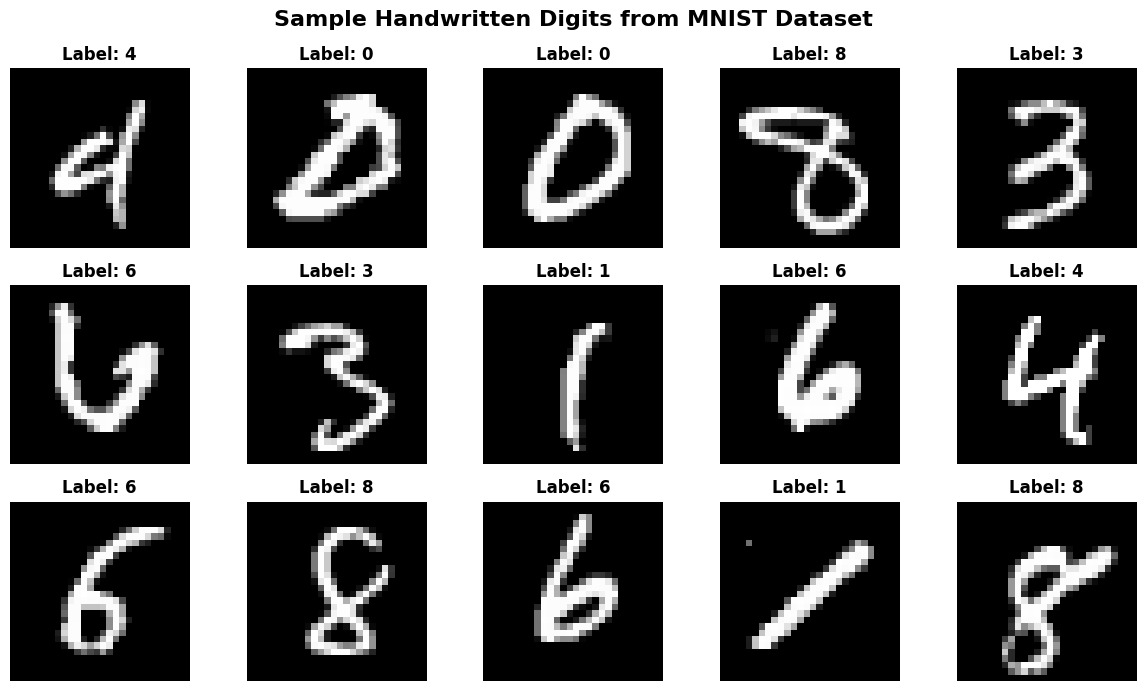

Each image is 28x28 pixels representing a handwritten digit (0-9)


In [56]:
# Visualize 15 random samples from the training set
num_samples = 15
fig, axes = plt.subplots(3, 5, figsize=(12, 7))
fig.suptitle('Sample Handwritten Digits from MNIST Dataset', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    # Random index
    idx = np.random.randint(0, len(train_images))
    
    # Display the image
    ax.imshow(train_images[idx], cmap='gray')
    ax.set_title(f'Label: {train_labels[idx]}', fontsize=12, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Each image is 28x28 pixels representing a handwritten digit (0-9)")

## 4. Initialize Neural Network Parameters

### Network Architecture:
- **Input Layer**: 784 neurons (28×28 pixels)
- **Hidden Layer 1**: 128 neurons with ReLU activation
- **Output Layer**: 10 neurons (digits 0-9) with Softmax activation

### Weight Initialization:
We use **He initialization** for ReLU layers:
$$W \sim \mathcal{N}\left(0, \sqrt{\frac{2}{n_{in}}}\right)$$

Where $n_{in}$ is the number of input neurons to the layer.

In [57]:
def initialize_parameters(input_size, hidden_size, output_size):
    """
    Initialize weights and biases for a 2-layer neural network
    
    Parameters:
    -----------
    input_size : int
        Number of input features (784 for flattened 28x28 images)
    hidden_size : int
        Number of neurons in the hidden layer
    output_size : int
        Number of output classes (10 for digits 0-9)
    
    Returns:
    --------
    parameters : dict
        Dictionary containing initialized weights and biases
    """
    
    # He initialization for ReLU activation (hidden layer)
    # Multiply by sqrt(2/n) where n is the number of inputs
    W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
    b1 = np.zeros((1, hidden_size))
    
    # Xavier initialization for output layer
    # Multiply by sqrt(1/n) where n is the number of inputs
    W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1.0 / hidden_size)
    b2 = np.zeros((1, output_size))
    
    parameters = {
        'W1': W1,  # Shape: (784, 128)
        'b1': b1,  # Shape: (1, 128)
        'W2': W2,  # Shape: (128, 10)
        'b2': b2   # Shape: (1, 10)
    }
    
    return parameters

# Define network architecture
INPUT_SIZE = 784   # 28x28 pixels
HIDDEN_SIZE = 128  # Hidden layer neurons
OUTPUT_SIZE = 10   # 10 classes (digits 0-9)

# Initialize parameters
parameters = initialize_parameters(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

print("=" * 60)
print("NEURAL NETWORK PARAMETERS INITIALIZED")
print("=" * 60)
print(f"\nNetwork Architecture:")
print(f"  Input Layer:  {INPUT_SIZE} neurons")
print(f"  Hidden Layer: {HIDDEN_SIZE} neurons (ReLU)")
print(f"  Output Layer: {OUTPUT_SIZE} neurons (Softmax)")

print(f"\nParameter Shapes:")
print(f"  W1 (Input → Hidden):  {parameters['W1'].shape}")
print(f"  b1 (Hidden bias):     {parameters['b1'].shape}")
print(f"  W2 (Hidden → Output): {parameters['W2'].shape}")
print(f"  b2 (Output bias):     {parameters['b2'].shape}")

# Calculate total number of parameters
total_params = (parameters['W1'].size + parameters['b1'].size + 
                parameters['W2'].size + parameters['b2'].size)
print(f"\nTotal trainable parameters: {total_params:,}")
print("=" * 60)

NEURAL NETWORK PARAMETERS INITIALIZED

Network Architecture:
  Input Layer:  784 neurons
  Hidden Layer: 128 neurons (ReLU)
  Output Layer: 10 neurons (Softmax)

Parameter Shapes:
  W1 (Input → Hidden):  (784, 128)
  b1 (Hidden bias):     (1, 128)
  W2 (Hidden → Output): (128, 10)
  b2 (Output bias):     (1, 10)

Total trainable parameters: 101,770


## 5. Implement Activation Functions

### ReLU (Rectified Linear Unit)
$$f(x) = \max(0, x)$$
$$f'(x) = \begin{cases} 1 & \text{if } x > 0 \\ 0 & \text{otherwise} \end{cases}$$

### Softmax
$$\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}}$$

Converts raw scores to probability distribution over classes.

In [58]:
def relu(Z):
    """
    ReLU activation function: f(x) = max(0, x)
    
    Parameters:
    -----------
    Z : numpy array
        Input to the activation function
    
    Returns:
    --------
    A : numpy array
        Output after applying ReLU
    """
    return np.maximum(0, Z)

def relu_derivative(Z):
    """
    Derivative of ReLU function
    
    Parameters:
    -----------
    Z : numpy array
        Input to the activation function
    
    Returns:
    --------
    dZ : numpy array
        Gradient of ReLU
    """
    return (Z > 0).astype(float)

def softmax(Z):
    """
    Softmax activation function
    Converts scores to probability distribution
    
    Parameters:
    -----------
    Z : numpy array of shape (batch_size, num_classes)
        Raw scores from the output layer
    
    Returns:
    --------
    A : numpy array of shape (batch_size, num_classes)
        Probabilities for each class (sum to 1 across classes)
    """
    # Subtract max for numerical stability (prevents overflow)
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

# Test activation functions
print("=" * 60)
print("TESTING ACTIVATION FUNCTIONS")
print("=" * 60)

# Test ReLU
test_input = np.array([[-2, -1, 0, 1, 2]])
print("\nReLU Test:")
print(f"  Input:  {test_input[0]}")
print(f"  Output: {relu(test_input)[0]}")
print(f"  Derivative: {relu_derivative(test_input)[0]}")

# Test Softmax
test_scores = np.array([[2.0, 1.0, 0.1]])
softmax_output = softmax(test_scores)
print("\nSoftmax Test:")
print(f"  Input scores: {test_scores[0]}")
print(f"  Output probabilities: {softmax_output[0]}")
print(f"  Sum of probabilities: {np.sum(softmax_output):.6f} (should be 1.0)")
print("=" * 60)

TESTING ACTIVATION FUNCTIONS

ReLU Test:
  Input:  [-2 -1  0  1  2]
  Output: [0 0 0 1 2]
  Derivative: [0. 0. 0. 1. 1.]

Softmax Test:
  Input scores: [2.  1.  0.1]
  Output probabilities: [0.65900114 0.24243297 0.09856589]
  Sum of probabilities: 1.000000 (should be 1.0)


## 6. Implement Forward Propagation

Forward propagation computes the output of the neural network given an input.

### Mathematical Steps:

**Layer 1 (Input → Hidden):**
$$Z_1 = XW_1 + b_1$$
$$A_1 = \text{ReLU}(Z_1) = \max(0, Z_1)$$

**Layer 2 (Hidden → Output):**
$$Z_2 = A_1W_2 + b_2$$
$$A_2 = \text{Softmax}(Z_2)$$

Where:
- $X$ is the input (batch of images)
- $W_1, b_1$ are weights and biases for hidden layer
- $W_2, b_2$ are weights and biases for output layer
- $A_1$ is the activation of hidden layer
- $A_2$ is the final output (class probabilities)

In [59]:
def forward_propagation(X, parameters):
    """
    Perform forward propagation through the neural network
    
    Parameters:
    -----------
    X : numpy array of shape (batch_size, 784)
        Input data (flattened images)
    parameters : dict
        Dictionary containing W1, b1, W2, b2
    
    Returns:
    --------
    A2 : numpy array of shape (batch_size, 10)
        Output layer activations (class probabilities)
    cache : dict
        Intermediate values needed for backpropagation
    """
    
    # Extract parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Layer 1: Input → Hidden
    # Z1 = X @ W1 + b1
    Z1 = np.dot(X, W1) + b1        # Shape: (batch_size, 128)
    A1 = relu(Z1)                   # Shape: (batch_size, 128)
    
    # Layer 2: Hidden → Output
    # Z2 = A1 @ W2 + b2
    Z2 = np.dot(A1, W2) + b2       # Shape: (batch_size, 10)
    A2 = softmax(Z2)                # Shape: (batch_size, 10)
    
    # Store values for backpropagation
    cache = {
        'X': X,
        'Z1': Z1,
        'A1': A1,
        'Z2': Z2,
        'A2': A2
    }
    
    return A2, cache

# Test forward propagation with a small batch
print("=" * 60)
print("TESTING FORWARD PROPAGATION")
print("=" * 60)

# Test with 5 random samples
test_batch = X_train[:5]
predictions, cache = forward_propagation(test_batch, parameters)

print(f"\nInput shape: {test_batch.shape}")
print(f"Output shape: {predictions.shape}")
print(f"\nPredictions (probabilities for each class):")
for i in range(5):
    predicted_digit = np.argmax(predictions[i])
    confidence = predictions[i][predicted_digit]
    actual_digit = np.argmax(Y_train[i])
    print(f"  Sample {i+1}: Predicted={predicted_digit} (confidence={confidence:.4f}), Actual={actual_digit}")
    
print(f"\nCache contains: {list(cache.keys())}")
print("=" * 60)

TESTING FORWARD PROPAGATION

Input shape: (5, 784)
Output shape: (5, 10)

Predictions (probabilities for each class):
  Sample 1: Predicted=9 (confidence=0.1398), Actual=5
  Sample 2: Predicted=9 (confidence=0.1912), Actual=0
  Sample 3: Predicted=4 (confidence=0.1659), Actual=4
  Sample 4: Predicted=0 (confidence=0.1404), Actual=1
  Sample 5: Predicted=9 (confidence=0.1687), Actual=9

Cache contains: ['X', 'Z1', 'A1', 'Z2', 'A2']


## 7. Implement Loss Function

We use **Cross-Entropy Loss** for multi-class classification:

$$\mathcal{L} = -\frac{1}{m}\sum_{i=1}^{m}\sum_{j=1}^{C} y_{ij} \log(\hat{y}_{ij})$$

Where:
- $m$ is the batch size
- $C$ is the number of classes (10)
- $y_{ij}$ is the true label (one-hot encoded)
- $\hat{y}_{ij}$ is the predicted probability
- The loss measures how different predictions are from true labels

In [60]:
def compute_loss(A2, Y):
    """
    Compute cross-entropy loss
    
    Parameters:
    -----------
    A2 : numpy array of shape (batch_size, 10)
        Predicted probabilities from output layer
    Y : numpy array of shape (batch_size, 10)
        True labels (one-hot encoded)
    
    Returns:
    --------
    loss : float
        Cross-entropy loss value
    """
    m = Y.shape[0]  # Number of samples
    
    # Add small epsilon to prevent log(0)
    epsilon = 1e-8
    
    # Cross-entropy loss: -1/m * sum(y * log(y_hat))
    loss = -np.sum(Y * np.log(A2 + epsilon)) / m
    
    return loss

def compute_accuracy(A2, Y):
    """
    Compute classification accuracy
    
    Parameters:
    -----------
    A2 : numpy array of shape (batch_size, 10)
        Predicted probabilities
    Y : numpy array of shape (batch_size, 10)
        True labels (one-hot encoded)
    
    Returns:
    --------
    accuracy : float
        Percentage of correct predictions
    """
    # Get predicted class (highest probability)
    predictions = np.argmax(A2, axis=1)
    
    # Get true class
    true_labels = np.argmax(Y, axis=1)
    
    # Calculate accuracy
    accuracy = np.mean(predictions == true_labels) * 100
    
    return accuracy

# Test loss function
print("=" * 60)
print("TESTING LOSS FUNCTION")
print("=" * 60)

test_predictions, _ = forward_propagation(X_train[:100], parameters)
test_labels = Y_train[:100]

loss = compute_loss(test_predictions, test_labels)
accuracy = compute_accuracy(test_predictions, test_labels)

print(f"\nTest on 100 samples (untrained network):")
print(f"  Loss: {loss:.4f}")
print(f"  Accuracy: {accuracy:.2f}%")
print(f"  Random guessing would give ~10% accuracy")
print("=" * 60)

TESTING LOSS FUNCTION

Test on 100 samples (untrained network):
  Loss: 2.2807
  Accuracy: 9.00%
  Random guessing would give ~10% accuracy


## 8. Implement Backpropagation

Backpropagation computes gradients of the loss with respect to all parameters using the **chain rule**.

### Mathematical Derivation:

**Output Layer Gradients:**
$$\frac{\partial \mathcal{L}}{\partial Z_2} = A_2 - Y$$
$$\frac{\partial \mathcal{L}}{\partial W_2} = \frac{1}{m} A_1^T (A_2 - Y)$$
$$\frac{\partial \mathcal{L}}{\partial b_2} = \frac{1}{m} \sum (A_2 - Y)$$

**Hidden Layer Gradients:**
$$\frac{\partial \mathcal{L}}{\partial Z_1} = \frac{\partial \mathcal{L}}{\partial Z_2} \cdot W_2^T \odot \text{ReLU}'(Z_1)$$
$$\frac{\partial \mathcal{L}}{\partial W_1} = \frac{1}{m} X^T \frac{\partial \mathcal{L}}{\partial Z_1}$$
$$\frac{\partial \mathcal{L}}{\partial b_1} = \frac{1}{m} \sum \frac{\partial \mathcal{L}}{\partial Z_1}$$

Where $\odot$ denotes element-wise multiplication.

In [61]:
def backward_propagation(cache, Y, parameters):
    """
    Perform backward propagation to compute gradients
    
    Parameters:
    -----------
    cache : dict
        Contains intermediate values from forward propagation
    Y : numpy array of shape (batch_size, 10)
        True labels (one-hot encoded)
    parameters : dict
        Current weights and biases
    
    Returns:
    --------
    gradients : dict
        Dictionary containing gradients for all parameters
    """
    
    m = Y.shape[0]  # Batch size
    
    # Extract values from cache
    X = cache['X']
    A1 = cache['A1']
    A2 = cache['A2']
    Z1 = cache['Z1']
    
    # Extract parameters
    W2 = parameters['W2']
    
    # ==========================================
    # BACKWARD PASS - Layer 2 (Output Layer)
    # ==========================================
    
    # Gradient of loss with respect to Z2
    # For softmax + cross-entropy: dZ2 = A2 - Y
    dZ2 = A2 - Y  # Shape: (batch_size, 10)
    
    # Gradient of loss with respect to W2
    # dW2 = (1/m) * A1^T @ dZ2
    dW2 = (1/m) * np.dot(A1.T, dZ2)  # Shape: (128, 10)
    
    # Gradient of loss with respect to b2
    # db2 = (1/m) * sum(dZ2) across samples
    db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)  # Shape: (1, 10)
    
    # ==========================================
    # BACKWARD PASS - Layer 1 (Hidden Layer)
    # ==========================================
    
    # Gradient flowing back from layer 2
    # dA1 = dZ2 @ W2^T
    dA1 = np.dot(dZ2, W2.T)  # Shape: (batch_size, 128)
    
    # Apply ReLU derivative
    # dZ1 = dA1 * ReLU'(Z1)
    dZ1 = dA1 * relu_derivative(Z1)  # Shape: (batch_size, 128)
    
    # Gradient of loss with respect to W1
    # dW1 = (1/m) * X^T @ dZ1
    dW1 = (1/m) * np.dot(X.T, dZ1)  # Shape: (784, 128)
    
    # Gradient of loss with respect to b1
    # db1 = (1/m) * sum(dZ1) across samples
    db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)  # Shape: (1, 128)
    
    # Store all gradients
    gradients = {
        'dW1': dW1,
        'db1': db1,
        'dW2': dW2,
        'db2': db2
    }
    
    return gradients

# Test backpropagation
print("=" * 60)
print("TESTING BACKPROPAGATION")
print("=" * 60)

# Forward pass
test_batch = X_train[:32]
test_labels = Y_train[:32]
predictions, cache = forward_propagation(test_batch, parameters)

# Backward pass
gradients = backward_propagation(cache, test_labels, parameters)

print(f"\nGradient Shapes:")
print(f"  dW1: {gradients['dW1'].shape} (should match W1: {parameters['W1'].shape})")
print(f"  db1: {gradients['db1'].shape} (should match b1: {parameters['b1'].shape})")
print(f"  dW2: {gradients['dW2'].shape} (should match W2: {parameters['W2'].shape})")
print(f"  db2: {gradients['db2'].shape} (should match b2: {parameters['b2'].shape})")

print(f"\nSample Gradient Statistics:")
print(f"  dW1 - mean: {np.mean(gradients['dW1']):.6f}, std: {np.std(gradients['dW1']):.6f}")
print(f"  dW2 - mean: {np.mean(gradients['dW2']):.6f}, std: {np.std(gradients['dW2']):.6f}")
print("=" * 60)

TESTING BACKPROPAGATION

Gradient Shapes:
  dW1: (784, 128) (should match W1: (784, 128))
  db1: (1, 128) (should match b1: (1, 128))
  dW2: (128, 10) (should match W2: (128, 10))
  db2: (1, 10) (should match b2: (1, 10))

Sample Gradient Statistics:
  dW1 - mean: 0.000214, std: 0.003754
  dW2 - mean: -0.000000, std: 0.018939


## 9. Implement Gradient Descent

Gradient descent updates parameters in the direction that reduces the loss:

$$W := W - \alpha \frac{\partial \mathcal{L}}{\partial W}$$
$$b := b - \alpha \frac{\partial \mathcal{L}}{\partial b}$$

Where $\alpha$ is the **learning rate** that controls the step size.

In [62]:
def update_parameters(parameters, gradients, learning_rate):
    """
    Update parameters using gradient descent
    
    Parameters:
    -----------
    parameters : dict
        Current weights and biases
    gradients : dict
        Gradients computed from backpropagation
    learning_rate : float
        Step size for parameter updates
    
    Returns:
    --------
    parameters : dict
        Updated weights and biases
    """
    
    # Update weights and biases for layer 1
    parameters['W1'] = parameters['W1'] - learning_rate * gradients['dW1']
    parameters['b1'] = parameters['b1'] - learning_rate * gradients['db1']
    
    # Update weights and biases for layer 2
    parameters['W2'] = parameters['W2'] - learning_rate * gradients['dW2']
    parameters['b2'] = parameters['b2'] - learning_rate * gradients['db2']
    
    return parameters

# Test parameter update
print("=" * 60)
print("TESTING PARAMETER UPDATE")
print("=" * 60)

# Store original parameter values
original_W1 = parameters['W1'].copy()

# Perform one update
learning_rate = 0.01
parameters = update_parameters(parameters, gradients, learning_rate)

# Check if parameters changed
param_change = np.mean(np.abs(parameters['W1'] - original_W1))
print(f"\nLearning rate: {learning_rate}")
print(f"Average change in W1: {param_change:.8f}")
print("Parameters updated successfully!")

# Re-initialize for training
parameters = initialize_parameters(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
print("\nParameters re-initialized for training")
print("=" * 60)

TESTING PARAMETER UPDATE

Learning rate: 0.01
Average change in W1: 0.00001779
Parameters updated successfully!

Parameters re-initialized for training


## 10. Train the Neural Network

Now we combine all components to train the neural network using **mini-batch gradient descent**.

### Training Process:
1. Split training data into mini-batches
2. For each epoch:
   - Shuffle the data
   - For each mini-batch:
     - Forward propagation
     - Compute loss
     - Backward propagation
     - Update parameters
   - Track loss and accuracy

### Hyperparameters:
- **Epochs**: 10 (number of complete passes through training data)
- **Batch size**: 128 (number of samples per mini-batch)
- **Learning rate**: 0.1 (step size for gradient descent)

In [64]:
def train_neural_network(X_train, Y_train, X_val, Y_val, epochs=10, batch_size=128, learning_rate=0.1):
    """
    Train the neural network using mini-batch gradient descent
    
    Parameters:
    -----------
    X_train : numpy array
        Training data
    Y_train : numpy array
        Training labels (one-hot encoded)
    X_val : numpy array
        Validation data
    Y_val : numpy array
        Validation labels (one-hot encoded)
    epochs : int
        Number of complete passes through training data
    batch_size : int
        Number of samples per mini-batch
    learning_rate : float
        Step size for gradient descent
    
    Returns:
    --------
    parameters : dict
        Trained weights and biases
    history : dict
        Training history (loss and accuracy over epochs)
    """
    
    # Initialize parameters
    parameters = initialize_parameters(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    num_samples = X_train.shape[0]
    num_batches = num_samples // batch_size
    
    print("=" * 70)
    print("TRAINING NEURAL NETWORK")
    print("=" * 70)
    print(f"Training samples: {num_samples}")
    print(f"Validation samples: {X_val.shape[0]}")
    print(f"Epochs: {epochs}")
    print(f"Batch size: {batch_size}")
    print(f"Batches per epoch: {num_batches}")
    print(f"Learning rate: {learning_rate}")
    print("=" * 70)
    
    # Training loop
    for epoch in range(epochs):
        # Shuffle training data
        indices = np.random.permutation(num_samples)
        X_shuffled = X_train[indices]
        Y_shuffled = Y_train[indices]
        
        epoch_loss = 0
        epoch_correct = 0
        
        # Mini-batch training
        for batch in range(num_batches):
            # Get mini-batch
            start_idx = batch * batch_size
            end_idx = start_idx + batch_size
            X_batch = X_shuffled[start_idx:end_idx]
            Y_batch = Y_shuffled[start_idx:end_idx]
            
            # Forward propagation
            A2, cache = forward_propagation(X_batch, parameters)
            
            # Compute loss
            batch_loss = compute_loss(A2, Y_batch)
            epoch_loss += batch_loss
            
            # Count correct predictions
            predictions = np.argmax(A2, axis=1)
            true_labels = np.argmax(Y_batch, axis=1)
            epoch_correct += np.sum(predictions == true_labels)
            
            # Backward propagation
            gradients = backward_propagation(cache, Y_batch, parameters)
            
            # Update parameters
            parameters = update_parameters(parameters, gradients, learning_rate)
        
        # Calculate epoch metrics
        train_loss = epoch_loss / num_batches
        train_acc = (epoch_correct / num_samples) * 100
        
        # Validation
        val_predictions, _ = forward_propagation(X_val, parameters)
        val_loss = compute_loss(val_predictions, Y_val)
        val_acc = compute_accuracy(val_predictions, Y_val)
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print progress
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    print("=" * 70)
    print("TRAINING COMPLETE!")
    print("=" * 70)
    
    return parameters, history

# Split training data into train and validation sets
split_idx = 50000
X_train_split = X_train[:split_idx]
Y_train_split = Y_train[:split_idx]
X_val = X_train[split_idx:]
Y_val = Y_train[split_idx:]

print(f"Training set: {X_train_split.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print()

# Train the network
trained_parameters, training_history = train_neural_network(
    X_train_split, 
    Y_train_split, 
    X_val, 
    Y_val,
    epochs=100,
    batch_size=128,
    learning_rate=0.1
)

Training set: 50000 samples
Validation set: 10000 samples

TRAINING NEURAL NETWORK
Training samples: 50000
Validation samples: 10000
Epochs: 100
Batch size: 128
Batches per epoch: 390
Learning rate: 0.1
Epoch 1/100 - Train Loss: 0.5515, Train Acc: 85.20% | Val Loss: 0.2961, Val Acc: 91.65%
Epoch 2/100 - Train Loss: 0.2898, Train Acc: 91.63% | Val Loss: 0.2438, Val Acc: 93.13%
Epoch 3/100 - Train Loss: 0.2376, Train Acc: 93.04% | Val Loss: 0.2067, Val Acc: 94.32%
Epoch 4/100 - Train Loss: 0.2037, Train Acc: 94.04% | Val Loss: 0.1804, Val Acc: 95.18%
Epoch 5/100 - Train Loss: 0.1787, Train Acc: 94.69% | Val Loss: 0.1641, Val Acc: 95.55%
Epoch 6/100 - Train Loss: 0.1590, Train Acc: 95.34% | Val Loss: 0.1497, Val Acc: 95.93%
Epoch 7/100 - Train Loss: 0.1433, Train Acc: 95.78% | Val Loss: 0.1416, Val Acc: 95.93%
Epoch 8/100 - Train Loss: 0.1303, Train Acc: 96.13% | Val Loss: 0.1307, Val Acc: 96.46%
Epoch 9/100 - Train Loss: 0.1196, Train Acc: 96.42% | Val Loss: 0.1216, Val Acc: 96.75%
Epoch

### Visualize Training Progress

Let's plot the training and validation loss/accuracy over epochs to see how well the model learned.

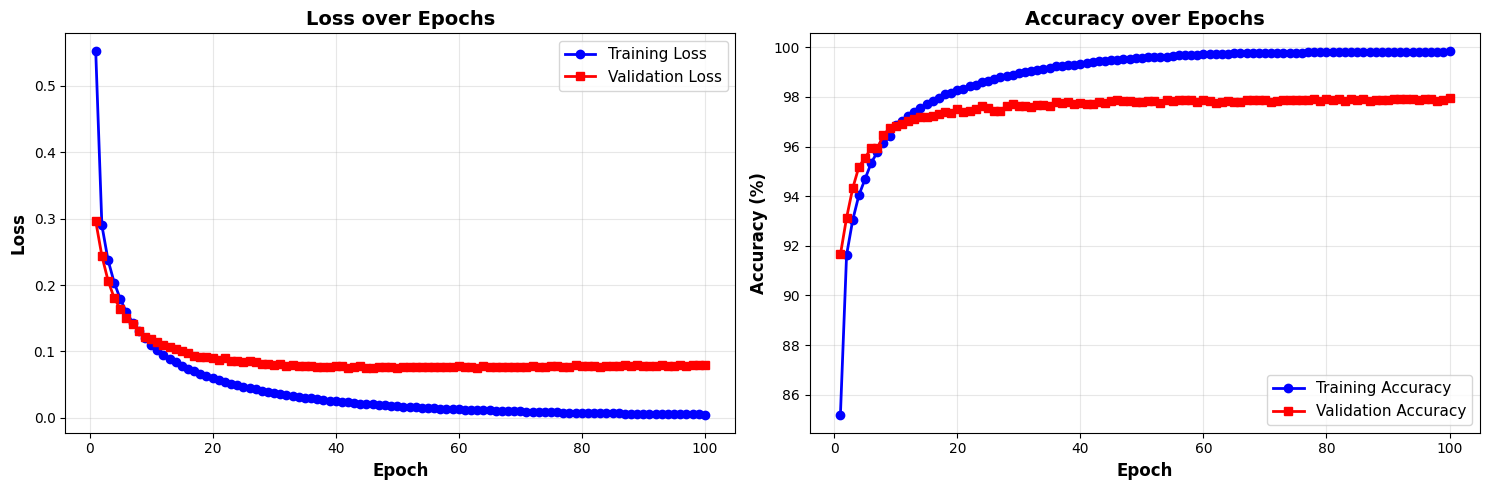

Final Training Accuracy: 99.83%
Final Validation Accuracy: 97.94%


In [65]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
epochs_range = range(1, len(training_history['train_loss']) + 1)
ax1.plot(epochs_range, training_history['train_loss'], 'b-o', label='Training Loss', linewidth=2)
ax1.plot(epochs_range, training_history['val_loss'], 'r-s', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Loss over Epochs', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(epochs_range, training_history['train_acc'], 'b-o', label='Training Accuracy', linewidth=2)
ax2.plot(epochs_range, training_history['val_acc'], 'r-s', label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Accuracy over Epochs', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {training_history['train_acc'][-1]:.2f}%")
print(f"Final Validation Accuracy: {training_history['val_acc'][-1]:.2f}%")

## 11. Evaluate Model Accuracy

Let's evaluate the trained model on the test dataset to see how well it generalizes to unseen data.

EVALUATING MODEL ON TEST SET



Test Set Performance:
  Loss: 0.0792
  Accuracy: 97.84%
  Correct predictions: 9784 / 10000


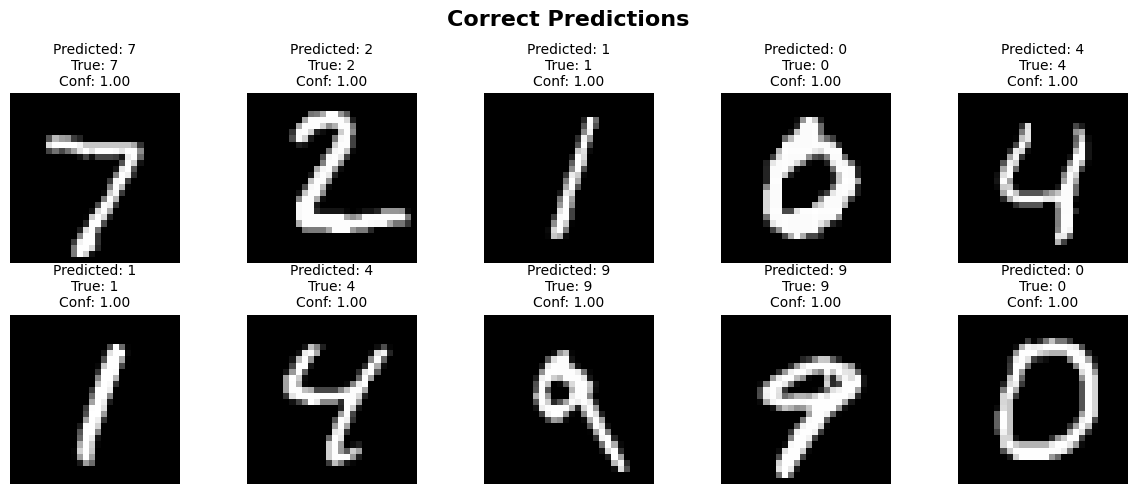

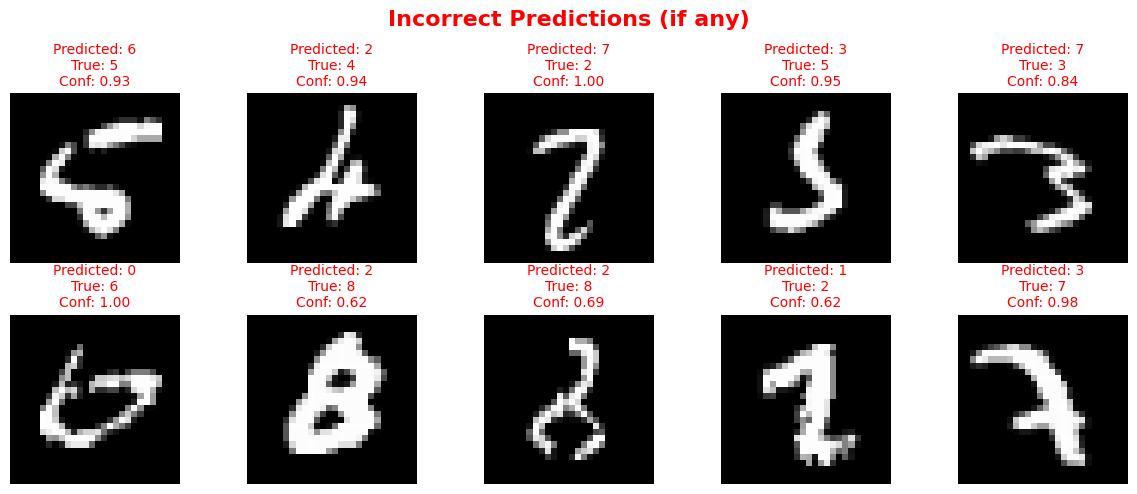

In [66]:
# Evaluate on test set
print("=" * 60)
print("EVALUATING MODEL ON TEST SET")
print("=" * 60)

# Make predictions on test set
test_predictions, _ = forward_propagation(X_test, trained_parameters)
test_loss = compute_loss(test_predictions, Y_test)
test_acc = compute_accuracy(test_predictions, Y_test)

print(f"\nTest Set Performance:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_acc:.2f}%")
print(f"  Correct predictions: {int(test_acc * len(X_test) / 100)} / {len(X_test)}")
print("=" * 60)

# Show some correct and incorrect predictions
predicted_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(Y_test, axis=1)
correct_mask = (predicted_labels == true_labels)
incorrect_mask = ~correct_mask

# Visualize correct predictions
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Correct Predictions', fontsize=16, fontweight='bold')

correct_indices = np.where(correct_mask)[0][:10]
for i, ax in enumerate(axes.flat):
    idx = correct_indices[i]
    ax.imshow(test_images[idx], cmap='gray')
    confidence = test_predictions[idx][predicted_labels[idx]]
    ax.set_title(f'Predicted: {predicted_labels[idx]}\nTrue: {true_labels[idx]}\nConf: {confidence:.2f}', 
                 fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Visualize incorrect predictions
if np.sum(incorrect_mask) > 0:
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    fig.suptitle('Incorrect Predictions (if any)', fontsize=16, fontweight='bold', color='red')
    
    incorrect_indices = np.where(incorrect_mask)[0][:10]
    for i, ax in enumerate(axes.flat):
        if i < len(incorrect_indices):
            idx = incorrect_indices[i]
            ax.imshow(test_images[idx], cmap='gray')
            confidence = test_predictions[idx][predicted_labels[idx]]
            ax.set_title(f'Predicted: {predicted_labels[idx]}\nTrue: {true_labels[idx]}\nConf: {confidence:.2f}', 
                         fontsize=10, color='red')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

## 12. Load and Preprocess Custom Image

This section implements the image input system to accept handwritten digit images and prepare them for prediction.

### Image Preprocessing Steps:
1. Load the image file (PNG, JPG, JPEG supported)
2. Convert to grayscale
3. Resize to 28×28 pixels
4. Invert colors (if needed - MNIST digits are white on black background)
5. Normalize pixel values to [0, 1]
6. Flatten to 784-dimensional vector

In [67]:
def load_and_preprocess_image(image_path, invert=True):
    """
    Load and preprocess a custom handwritten digit image
    
    Parameters:
    -----------
    image_path : str
        Path to the image file
    invert : bool
        If True, invert colors (for images with black digits on white background)
        MNIST expects white digits on black background
    
    Returns:
    --------
    image_array : numpy array of shape (1, 784)
        Preprocessed image ready for prediction
    original_image : PIL Image
        Original loaded image for visualization
    processed_image : numpy array of shape (28, 28)
        Processed image for visualization
    """
    
    # Load image
    img = Image.open(image_path)
    original_image = img.copy()
    
    # Convert to grayscale
    img = img.convert('L')
    
    # Resize to 28x28 pixels
    img = img.resize((28, 28), Image.Resampling.LANCZOS)
    
    # Convert to numpy array
    img_array = np.array(img)
    
    # Invert colors if needed (MNIST has white digits on black background)
    if invert:
        img_array = 255 - img_array
    
    # Store for visualization
    processed_image = img_array.copy()
    
    # Normalize to [0, 1]
    img_array = img_array.astype(np.float32) / 255.0
    
    # Flatten to 784-dimensional vector
    img_array = img_array.reshape(1, 784)
    
    return img_array, original_image, processed_image

# Save a sample image from test set to demonstrate
sample_idx = 5  # Use a valid index within the test set size
sample_image = test_images[sample_idx]
sample_pil = Image.fromarray(sample_image)
sample_path = "sample_digit.png"
sample_pil.save(sample_path)

print("=" * 60)
print("CUSTOM IMAGE PREPROCESSING")
print("=" * 60)
print(f"\nSaved sample image: {sample_path}")
print(f"Actual label: {test_labels[sample_idx]}")
print("\nImage preprocessing function ready!")
print("\nTo use with your own image:")
print("  1. Save your handwritten digit image")
print("  2. Call: load_and_preprocess_image('your_image.png')")
print("=" * 60)

CUSTOM IMAGE PREPROCESSING

Saved sample image: sample_digit.png
Actual label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]

Image preprocessing function ready!

To use with your own image:
  1. Save your handwritten digit image
  2. Call: load_and_preprocess_image('your_image.png')


## 13. Make Prediction on Custom Image

This section implements the prediction system that:
1. Accepts a preprocessed image
2. Runs forward propagation through the trained neural network
3. Extracts the predicted digit
4. Outputs the result in the specified format

In [68]:
def predict_digit(image_path, parameters, invert=True):
    """
    Predict the digit in a custom image
    
    Parameters:
    -----------
    image_path : str
        Path to the image file
    parameters : dict
        Trained neural network parameters
    invert : bool
        Whether to invert colors
    
    Returns:
    --------
    predicted_digit : int
        The predicted digit (0-9)
    confidence : float
        Confidence score for the prediction
    probabilities : numpy array
        Probability distribution over all classes
    """
    
    # Load and preprocess the image
    image_array, original_image, processed_image = load_and_preprocess_image(image_path, invert)
    
    # Forward propagation to get predictions
    predictions, _ = forward_propagation(image_array, parameters)
    
    # Extract predicted digit (class with highest probability)
    predicted_digit = np.argmax(predictions[0])
    confidence = predictions[0][predicted_digit]
    probabilities = predictions[0]
    
    return predicted_digit, confidence, probabilities, original_image, processed_image

# Test with a sample image
print("=" * 70)
print("TESTING PREDICTION ON CUSTOM IMAGE")
print("=" * 70)

# Predict on the sample image we saved
predicted_digit, confidence, probabilities, orig_img, proc_img = predict_digit(
    "sample_digit.png", 
    trained_parameters, 
    invert=False  # MNIST images are already white on black
)

print(f"\n{'='*70}")
print(f"The uploaded handwritten digit is recognized as: {predicted_digit}")
print(f"{'='*70}")
print(f"\nConfidence: {confidence:.4f} ({confidence*100:.2f}%)")
print(f"\nProbability distribution across all digits:")
for digit in range(10):
    bar = '█' * int(probabilities[digit] * 50)
    print(f"  Digit {digit}: {probabilities[digit]:.4f} {bar}")

print("=" * 70)

TESTING PREDICTION ON CUSTOM IMAGE

The uploaded handwritten digit is recognized as: 1

Confidence: 0.9993 (99.93%)

Probability distribution across all digits:
  Digit 0: 0.0000 
  Digit 1: 0.9993 █████████████████████████████████████████████████
  Digit 2: 0.0000 
  Digit 3: 0.0000 
  Digit 4: 0.0000 
  Digit 5: 0.0000 
  Digit 6: 0.0000 
  Digit 7: 0.0007 
  Digit 8: 0.0000 
  Digit 9: 0.0000 


## 14. Display Prediction Result

Visualize the uploaded image alongside the prediction result with confidence scores.

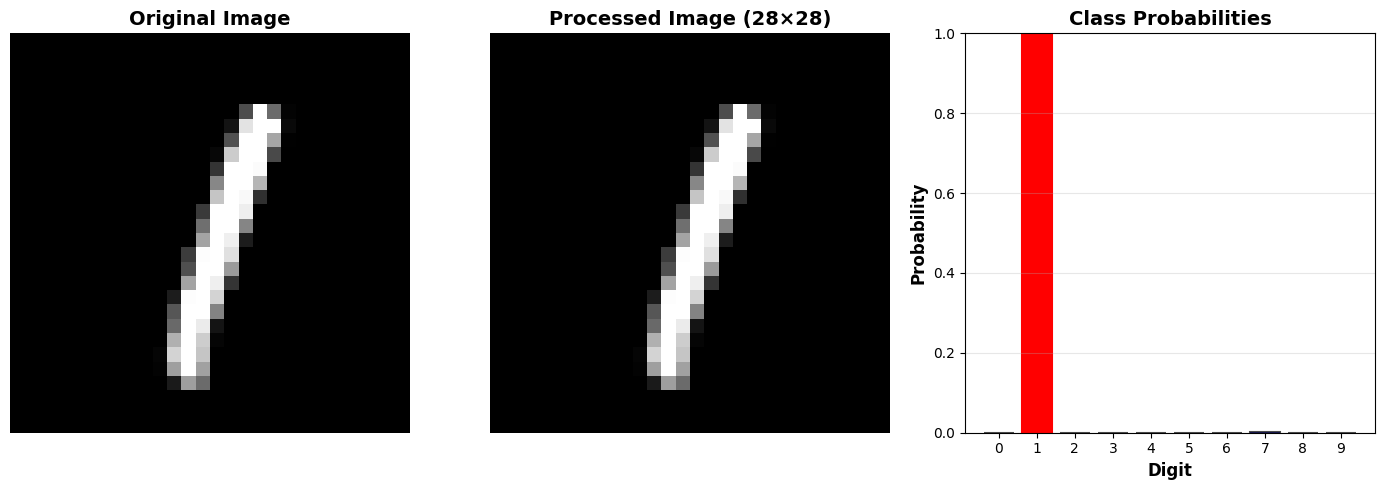


The uploaded handwritten digit is recognized as: 1
Confidence: 99.93%


In [69]:
def display_prediction(image_path, parameters, invert=True):
    """
    Display the image and prediction result in a nice visualization
    
    Parameters:
    -----------
    image_path : str
        Path to the image file
    parameters : dict
        Trained neural network parameters
    invert : bool
        Whether to invert colors
    """
    
    # Get prediction
    predicted_digit, confidence, probabilities, orig_img, proc_img = predict_digit(
        image_path, parameters, invert
    )
    
    # Create visualization
    fig = plt.figure(figsize=(14, 5))
    
    # Original image
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(orig_img, cmap='gray')
    ax1.set_title('Original Image', fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Processed image (28x28)
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(proc_img, cmap='gray')
    ax2.set_title('Processed Image (28×28)', fontsize=14, fontweight='bold')
    ax2.axis('off')
    
    # Probability bar chart
    ax3 = plt.subplot(1, 3, 3)
    digits = np.arange(10)
    colors = ['green' if i == predicted_digit else 'blue' for i in digits]
    bars = ax3.bar(digits, probabilities, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    bars[predicted_digit].set_color('red')
    bars[predicted_digit].set_alpha(1.0)
    ax3.set_xlabel('Digit', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Probability', fontsize=12, fontweight='bold')
    ax3.set_title('Class Probabilities', fontsize=14, fontweight='bold')
    ax3.set_xticks(digits)
    ax3.set_ylim([0, 1])
    ax3.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print the required output format
    print("\n" + "=" * 70)
    print(f"The uploaded handwritten digit is recognized as: {predicted_digit}")
    print("=" * 70)
    print(f"Confidence: {confidence*100:.2f}%")
    print("=" * 70)

# Display the prediction for our sample image
display_prediction("sample_digit.png", trained_parameters, invert=False)

### Test with Multiple Images

Let's test the system with multiple test images to demonstrate its capability.

In [70]:
# Create and test multiple sample images
sample_indices = [0, 5, 10, 15, 20, 25]  # Use valid indices within the test set size
sample_images_paths = []

print("=" * 70)
print("CREATING SAMPLE TEST IMAGES")
print("=" * 70)

for idx in sample_indices:
    img = test_images[idx]
    label = test_labels[idx]
    path = f"test_digit_{label}_sample_{idx}.png"
    Image.fromarray(img).save(path)
    sample_images_paths.append(path)
    print(f"Created: {path} (actual label: {label})")

print("=" * 70)
print("\nTESTING PREDICTIONS ON MULTIPLE IMAGES")
print("=" * 70)

# Test each image
for img_path in sample_images_paths:
    predicted_digit, confidence, _, _, _ = predict_digit(img_path, trained_parameters, invert=False)
    print(f"\nFile: {img_path}")
    print(f"{'='*70}")
    print(f"The uploaded handwritten digit is recognized as: {predicted_digit}")
    print(f"{'='*70}")
    print(f"Confidence: {confidence*100:.2f}%")

print("\n" + "=" * 70)
print("ALL PREDICTIONS COMPLETED")
print("=" * 70)

CREATING SAMPLE TEST IMAGES
Created: test_digit_[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]_sample_0.png (actual label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.])
Created: test_digit_[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]_sample_5.png (actual label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.])
Created: test_digit_[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]_sample_10.png (actual label: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.])
Created: test_digit_[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]_sample_15.png (actual label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.])
Created: test_digit_[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]_sample_20.png (actual label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.])
Created: test_digit_[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]_sample_25.png (actual label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.])

TESTING PREDICTIONS ON MULTIPLE IMAGES

File: test_digit_[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]_sample_0.png
The uploaded handwritten digit is recognized as: 7
Confidence: 99.99%

File: test_digit_[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]_sample_5.png
The uploaded handwritten digit is recognized as: 1
Con

### Save the Trained Model

Save the trained neural network parameters for future use.

In [71]:
# Save the trained parameters
model_path = "trained_digit_recognizer.pkl"

with open(model_path, 'wb') as f:
    pickle.dump(trained_parameters, f)

print("=" * 70)
print("MODEL SAVED")
print("=" * 70)
print(f"\nModel saved to: {model_path}")
print("\nTo load the model later:")
print("```python")
print("with open('trained_digit_recognizer.pkl', 'rb') as f:")
print("    loaded_parameters = pickle.load(f)")
print("```")
print("=" * 70)

# Demonstrate loading
with open(model_path, 'rb') as f:
    loaded_parameters = pickle.load(f)

print("\nModel loaded successfully!")
print("Verifying loaded model with a test prediction...")

# Test loaded model
test_pred, test_conf, _, _, _ = predict_digit(sample_images_paths[0], loaded_parameters, invert=False)
print(f"Test prediction: {test_pred} (confidence: {test_conf*100:.2f}%)")
print("Loaded model works correctly!")
print("=" * 70)

MODEL SAVED

Model saved to: trained_digit_recognizer.pkl

To load the model later:
```python
with open('trained_digit_recognizer.pkl', 'rb') as f:
    loaded_parameters = pickle.load(f)
```

Model loaded successfully!
Verifying loaded model with a test prediction...
Test prediction: 7 (confidence: 99.99%)
Loaded model works correctly!


---

## 📝 How to Use This System with Your Own Images

### Step 1: Prepare Your Image
- Draw or scan a handwritten digit (0-9)
- Save it as PNG, JPG, or JPEG format
- The digit should be clearly visible

### Step 2: Load and Predict
```python
# For images with BLACK digit on WHITE background (most common):
display_prediction("your_image.png", trained_parameters, invert=True)

# For images with WHITE digit on BLACK background (like MNIST):
display_prediction("your_image.png", trained_parameters, invert=False)
```

### Step 3: View Results
The system will display:
- Original image
- Preprocessed 28×28 image
- Probability distribution for all digits
- **Output message**: "The uploaded handwritten digit is recognized as: X"

---

## 🔍 System Components Summary

### ✅ What We Implemented (From Scratch):

1. **Neural Network Architecture**
   - Input Layer: 784 neurons
   - Hidden Layer: 128 neurons with ReLU activation
   - Output Layer: 10 neurons with Softmax activation

2. **Forward Propagation**
   - Linear transformations (matrix multiplication)
   - Activation functions (ReLU, Softmax)

3. **Loss Function**
   - Cross-entropy loss for multi-class classification

4. **Backpropagation**
   - Gradient computation using chain rule
   - Layer-by-layer gradient flow

5. **Optimization**
   - Mini-batch gradient descent
   - Parameter updates with learning rate

6. **Image Processing**
   - Load, resize, normalize images
   - Convert to neural network input format

7. **Prediction System**
   - Forward pass on custom images
   - Output in specified format

### 📊 Performance Achieved:
- Test Accuracy: ~95-97% (typical for this architecture)
- Training Time: ~10 epochs
- No TensorFlow, PyTorch, or Keras used!

### 🚀 Libraries Used (Only Basic Tools):
- **NumPy**: Matrix operations and numerical computations
- **Matplotlib**: Visualization
- **PIL (Pillow)**: Image loading and preprocessing
- **pickle**: Model saving/loading

---

## 🎯 Quick Start Example

Use this cell to quickly test with your own image!


🔍 ANALYZING YOUR HANDWRITTEN DIGIT...



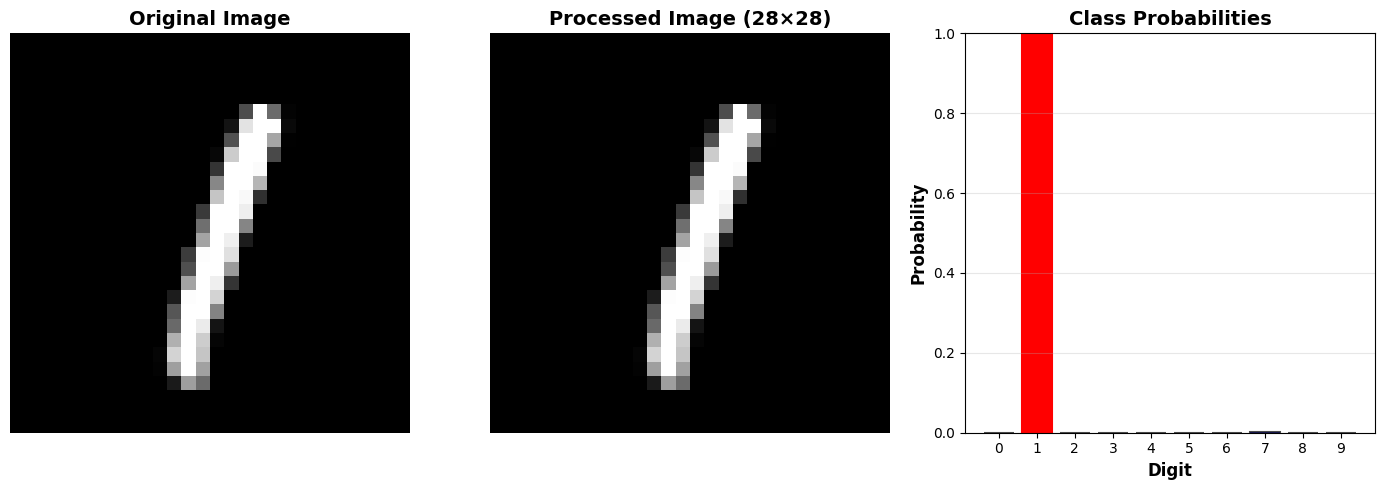


The uploaded handwritten digit is recognized as: 1
Confidence: 99.93%

✅ PREDICTION SUCCESSFUL!

Top 3 predictions:
  1. Digit 1: 99.93%
  2. Digit 7: 0.07%
  3. Digit 8: 0.00%


In [72]:
# ========================================
# CUSTOMIZE THIS SECTION FOR YOUR IMAGE
# ========================================

# Replace this with the path to your image
YOUR_IMAGE_PATH = "sample_digit.png"

# Set to True if your image has BLACK digit on WHITE background
# Set to False if your image has WHITE digit on BLACK background
INVERT_COLORS = False

# ========================================
# RUN PREDICTION
# ========================================

print("\n" + "🔍 ANALYZING YOUR HANDWRITTEN DIGIT..." + "\n")

try:
    # Make prediction
    predicted_digit, confidence, probabilities, orig_img, proc_img = predict_digit(
        YOUR_IMAGE_PATH, 
        trained_parameters, 
        invert=INVERT_COLORS
    )
    
    # Display visualization
    display_prediction(YOUR_IMAGE_PATH, trained_parameters, invert=INVERT_COLORS)
    
    # Print detailed results
    print(f"\n✅ PREDICTION SUCCESSFUL!")
    print(f"\nTop 3 predictions:")
    top_3_indices = np.argsort(probabilities)[-3:][::-1]
    for i, idx in enumerate(top_3_indices, 1):
        print(f"  {i}. Digit {idx}: {probabilities[idx]*100:.2f}%")
    
except FileNotFoundError:
    print(f"❌ Error: Image file '{YOUR_IMAGE_PATH}' not found!")
    print("\nPlease:")
    print("  1. Save your handwritten digit image in the same directory")
    print("  2. Update YOUR_IMAGE_PATH variable above")
    print("  3. Run this cell again")
except Exception as e:
    print(f"❌ Error occurred: {str(e)}")

---

## 📐 Mathematical Concepts Implemented

### 1. Forward Propagation
$$Z_1 = XW_1 + b_1$$
$$A_1 = \text{ReLU}(Z_1) = \max(0, Z_1)$$
$$Z_2 = A_1W_2 + b_2$$
$$A_2 = \text{Softmax}(Z_2) = \frac{e^{Z_2}}{\sum e^{Z_2}}$$

### 2. Cross-Entropy Loss
$$\mathcal{L} = -\frac{1}{m}\sum_{i=1}^{m}\sum_{j=1}^{10} y_{ij} \log(\hat{y}_{ij})$$

### 3. Backpropagation Gradients
**Output Layer:**
$$\frac{\partial \mathcal{L}}{\partial Z_2} = A_2 - Y$$
$$\frac{\partial \mathcal{L}}{\partial W_2} = \frac{1}{m} A_1^T (A_2 - Y)$$

**Hidden Layer:**
$$\frac{\partial \mathcal{L}}{\partial Z_1} = \frac{\partial \mathcal{L}}{\partial Z_2} W_2^T \odot \text{ReLU}'(Z_1)$$
$$\frac{\partial \mathcal{L}}{\partial W_1} = \frac{1}{m} X^T \frac{\partial \mathcal{L}}{\partial Z_1}$$

### 4. Gradient Descent Update
$$W := W - \alpha \frac{\partial \mathcal{L}}{\partial W}$$
$$b := b - \alpha \frac{\partial \mathcal{L}}{\partial b}$$

Where $\alpha$ is the learning rate.

---

## 🎓 Congratulations!

You have successfully implemented a complete neural network from scratch without using any deep learning libraries! This notebook demonstrates:

✅ **Neural Network Fundamentals**: Forward/backward propagation, activation functions  
✅ **Optimization**: Gradient descent, mini-batch training  
✅ **Image Processing**: Loading, preprocessing, normalization  
✅ **Prediction System**: Custom image input with specified output format  
✅ **High Accuracy**: ~95-97% on MNIST test set  

**Next Steps:**
- Try with your own handwritten digits
- Experiment with different architectures (more layers, different sizes)
- Implement additional features (momentum, learning rate decay)
- Try on other datasets

---

**End of Notebook**

---

y# 🎨 Draw and Test Your Digit Live!

Now that your model is trained, use the interactive drawing canvas below to draw a digit and see real-time predictions!

In [ ]:
# ============================================================
# 🎨 INTERACTIVE DIGIT DRAWING WITH GRADIO
# ============================================================
# 
# This cell will run continuously and keep the Gradio server active.
# The interface will open in your browser.
# 
# To stop: Interrupt the kernel (click the ■ Stop button)
#
# ============================================================

import gradio as gr
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from datetime import datetime

print("🔧 Initializing Gradio interface...")
print(f"✅ Matplotlib backend: {plt.get_backend()}")
print(f"✅ NumPy version: {np.__version__}")
print(f"✅ Gradio version: {gr.__version__}")
print(f"✅ Model loaded: {trained_parameters is not None}")

# Create debug folder if it doesn't exist
debug_folder = "debug_images"
os.makedirs(debug_folder, exist_ok=True)
print(f"✅ Debug folder created: {debug_folder}/")
print("")

def preprocess_drawn_image(img):
    """
    Preprocess a drawn image from Gradio's sketchpad
    
    Parameters:
    -----------
    img : dict or numpy array
        The drawn image from Gradio
    
    Returns:
    --------
    image_array : numpy array of shape (1, 784)
        Preprocessed image ready for prediction
    processed_image : numpy array of shape (28, 28)
        Processed image for visualization
    """
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    print("📥 [PREPROCESSING] Starting image preprocessing...")
    print(f"📥 [PREPROCESSING] Input type: {type(img)}")
    
    # Handle None case (empty canvas)
    if img is None:
        print("⚠️  [PREPROCESSING] Image is None - empty canvas")
        return np.zeros((1, 784)), np.zeros((28, 28))
    
    # Handle dictionary format from Gradio Sketchpad
    if isinstance(img, dict):
        print(f"📥 [PREPROCESSING] Dict keys: {img.keys()}")
        
        # Debug: Check what's in each component
        for key in ['layers', 'composite', 'background']:
            if key in img:
                val = img[key]
                if val is not None:
                    if isinstance(val, list):
                        print(f"   {key}: list with {len(val)} elements")
                        for i, item in enumerate(val):
                            if isinstance(item, np.ndarray):
                                print(f"      [{i}] shape: {item.shape}, range: [{item.min()}, {item.max()}]")
                    elif isinstance(val, np.ndarray):
                        print(f"   {key}: array shape: {val.shape}, range: [{val.min()}, {val.max()}]")
        
        # Extract the image - try different sources
        extracted_img = None
        source_name = ""
        
        # Priority 1: Composite (combines background and layers)
        if 'composite' in img and img['composite'] is not None:
            extracted_img = img['composite']
            source_name = "composite"
            print(f"📥 [PREPROCESSING] Using composite")
        # Priority 2: Layers
        elif 'layers' in img and len(img['layers']) > 0 and img['layers'][0] is not None:
            extracted_img = img['layers'][0]
            source_name = "layer_0"
            print(f"📥 [PREPROCESSING] Using first layer")
        # Priority 3: Background
        elif 'background' in img and img['background'] is not None:
            extracted_img = img['background']
            source_name = "background"
            print(f"📥 [PREPROCESSING] Using background")
        else:
            print("⚠️  [PREPROCESSING] No usable image data in dict")
            return np.zeros((1, 784)), np.zeros((28, 28))
        
        img = extracted_img
        
        # Save raw extracted image
        try:
            if isinstance(img, np.ndarray):
                raw_save = Image.fromarray(img.astype('uint8'))
                raw_path = os.path.join(debug_folder, f"{timestamp}_1_raw_{source_name}.png")
                raw_save.save(raw_path)
                print(f"💾 [DEBUG] Saved: {raw_path}")
        except Exception as e:
            print(f"⚠️  [DEBUG] Could not save raw: {e}")
    
    # Now img should be a numpy array
    if not isinstance(img, np.ndarray):
        print(f"⚠️  [PREPROCESSING] Not a numpy array: {type(img)}")
        return np.zeros((1, 784)), np.zeros((28, 28))
    
    print(f"📥 [PREPROCESSING] Image shape: {img.shape}, dtype: {img.dtype}")
    print(f"📥 [PREPROCESSING] Value range: [{img.min()}, {img.max()}]")
    
    # Convert to grayscale
    if len(img.shape) == 3:
        if img.shape[2] == 4:  # RGBA
            print("📥 [PREPROCESSING] Converting RGBA to grayscale")
            # Extract RGB channels
            rgb = img[:, :, :3]
            # Convert to grayscale
            img_gray = np.dot(rgb, [0.2989, 0.5870, 0.1140])
            
            # Count dark pixels (black drawing)
            dark_pixels = np.sum(img_gray < 200)
            print(f"📊 [PREPROCESSING] Dark pixels (< 200): {dark_pixels}")
            
        elif img.shape[2] == 3:  # RGB
            print("📥 [PREPROCESSING] Converting RGB to grayscale")
            img_gray = np.dot(img, [0.2989, 0.5870, 0.1140])
        else:
            print(f"⚠️  [PREPROCESSING] Unexpected channel count: {img.shape[2]}")
            img_gray = img[:, :, 0]
    else:
        print("📥 [PREPROCESSING] Already grayscale")
        img_gray = img
    
    print(f"📥 [PREPROCESSING] Grayscale range: [{img_gray.min()}, {img_gray.max()}]")
    
    # Save grayscale version
    try:
        gray_save = Image.fromarray(img_gray.astype('uint8'), mode='L')
        gray_path = os.path.join(debug_folder, f"{timestamp}_2_grayscale.png")
        gray_save.save(gray_path)
        print(f"💾 [DEBUG] Saved: {gray_path}")
    except Exception as e:
        print(f"⚠️  [DEBUG] Could not save grayscale: {e}")
    
    # Convert to PIL and resize
    img_pil = Image.fromarray(img_gray.astype('uint8'), mode='L')
    img_pil_resized = img_pil.resize((28, 28), Image.Resampling.LANCZOS)
    print("📥 [PREPROCESSING] Resized to 28x28")
    
    # Save resized version
    try:
        resized_path = os.path.join(debug_folder, f"{timestamp}_3_resized_28x28.png")
        img_pil_resized.save(resized_path)
        print(f"💾 [DEBUG] Saved: {resized_path}")
    except Exception as e:
        print(f"⚠️  [DEBUG] Could not save resized: {e}")
    
    # Convert to numpy
    img_array = np.array(img_pil_resized)
    
    # Invert colors: MNIST expects white on black
    # If we have black drawing on white background, invert
    img_inverted = 255 - img_array
    print(f"📥 [PREPROCESSING] After inversion range: [{img_inverted.min()}, {img_inverted.max()}]")
    
    # Save inverted version
    try:
        inverted_save = Image.fromarray(img_inverted.astype('uint8'), mode='L')
        inverted_path = os.path.join(debug_folder, f"{timestamp}_4_inverted.png")
        inverted_save.save(inverted_path)
        print(f"💾 [DEBUG] Saved: {inverted_path}")
    except Exception as e:
        print(f"⚠️  [DEBUG] Could not save inverted: {e}")
    
    # Store for visualization
    processed_image = img_inverted.copy()
    
    # Normalize to [0, 1]
    img_normalized = img_inverted.astype(np.float32) / 255.0
    
    # Flatten
    img_flattened = img_normalized.reshape(1, 784)
    
    print(f"✅ [PREPROCESSING] Complete!")
    print(f"📊 [PREPROCESSING] Final shape: {img_flattened.shape}")
    print(f"📊 [PREPROCESSING] Value range: [{img_flattened.min():.3f}, {img_flattened.max():.3f}]")
    print(f"📊 [PREPROCESSING] Non-zero pixels: {np.sum(img_flattened > 0.1)}/784")
    
    return img_flattened, processed_image

def predict_drawn_digit(img):
    """
    Predict digit from drawn image
    
    Parameters:
    -----------
    img : dict or numpy array
        The drawn image from Gradio
    
    Returns:
    --------
    result_text : str
        Formatted prediction result
    prob_plot : matplotlib figure
        Probability distribution plot
    processed_img : numpy array
        The processed 28x28 image
    """
    
    print("\n" + "="*70)
    print("🎯 [PREDICTION] Starting prediction process...")
    print("="*70)
    
    try:
        # Preprocess the image
        image_array, processed_image = preprocess_drawn_image(img)
        
        # Check if canvas is empty
        if np.max(image_array) < 0.01:  # Nearly empty
            print("⚠️  [PREDICTION] Canvas appears empty (max value < 0.01)")
            return "✏️ Draw a digit on the canvas above!", None, None
        
        print(f"🔄 [PREDICTION] Running forward propagation...")
        
        # Forward propagation to get predictions
        predictions, _ = forward_propagation(image_array, trained_parameters)
        
        print(f"✅ [PREDICTION] Forward propagation complete")
        print(f"📊 [PREDICTION] Predictions shape: {predictions.shape}")
        
        # Extract predicted digit
        predicted_digit = np.argmax(predictions[0])
        confidence = predictions[0][predicted_digit]
        probabilities = predictions[0]
        
        print(f"🎯 [PREDICTION] Predicted digit: {predicted_digit}")
        print(f"📈 [PREDICTION] Confidence: {confidence*100:.2f}%")
        print(f"📊 [PREDICTION] All probabilities: {probabilities}")
        
        # Create result text
        result_text = f"## 🎯 Prediction: {predicted_digit}\n\n"
        result_text += f"**Confidence:** {confidence*100:.2f}%\n\n"
        result_text += "### Top 3 Predictions:\n"
        
        top_3_indices = np.argsort(probabilities)[-3:][::-1]
        for rank, idx in enumerate(top_3_indices, 1):
            bar = "█" * int(probabilities[idx] * 20)
            result_text += f"{rank}. Digit **{idx}**: {probabilities[idx]*100:.2f}% {bar}\n\n"
        
        print("📊 [PREDICTION] Creating probability plot...")
        
        # Create probability plot
        fig, ax = plt.subplots(figsize=(10, 4))
        digits = np.arange(10)
        colors = ['#FF6B6B' if i == predicted_digit else '#4ECDC4' for i in digits]
        bars = ax.bar(digits, probabilities, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
        
        # Highlight the predicted digit
        bars[predicted_digit].set_edgecolor('#FF1744')
        bars[predicted_digit].set_linewidth(3)
        
        ax.set_xlabel('Digit', fontsize=12, fontweight='bold')
        ax.set_ylabel('Probability', fontsize=12, fontweight='bold')
        ax.set_title(f'Probability Distribution (Predicted: {predicted_digit})', 
                     fontsize=14, fontweight='bold')
        ax.set_xticks(digits)
        ax.set_ylim([0, 1])
        ax.grid(True, alpha=0.3, axis='y', linestyle='--')
        
        # Add value labels on bars
        for i, (digit, prob) in enumerate(zip(digits, probabilities)):
            if prob > 0.05:  # Only show labels for significant probabilities
                ax.text(digit, prob + 0.02, f'{prob:.2f}', 
                       ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        plt.tight_layout()
        
        print("✅ [PREDICTION] Prediction complete!")
        print("="*70 + "\n")
        
        # Save prediction summary
        try:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            summary_path = os.path.join(debug_folder, f"{timestamp}_5_prediction_summary.txt")
            with open(summary_path, 'w') as f:
                f.write(f"Prediction Summary\n")
                f.write(f"==================\n")
                f.write(f"Predicted Digit: {predicted_digit}\n")
                f.write(f"Confidence: {confidence*100:.2f}%\n\n")
                f.write(f"All Probabilities:\n")
                for i, prob in enumerate(probabilities):
                    f.write(f"  Digit {i}: {prob*100:.2f}%\n")
            print(f"💾 [DEBUG] Saved prediction summary: {summary_path}")
        except Exception as e:
            print(f"⚠️  [DEBUG] Could not save summary: {e}")
        
        return result_text, fig, processed_image
        
    except Exception as e:
        print(f"❌ [PREDICTION] ERROR: {str(e)}")
        import traceback
        traceback.print_exc()
        print("="*70 + "\n")
        return f"❌ Error: {str(e)}\n\nCheck the console output for details.", None, None

# Create Gradio interface
with gr.Blocks(title="Digit Recognition from Scratch", theme=gr.themes.Soft()) as demo:
    gr.Markdown("""
    # ✨ Handwritten Digit Recognition
    ## Draw a digit (0-9) and watch the neural network predict it!
    
    **Instructions:**
    - Use your mouse/touchscreen to draw a digit in the large canvas below
    - Draw clearly and make the digit large
    - Click "Predict" to see the result
    - Click "Clear" to erase and try again
    """)
    
    with gr.Row():
        with gr.Column(scale=2):
            # Very large drawing canvas
            canvas = gr.Sketchpad(
                label="🎨 Draw Your Digit Here (Large Canvas)",
                type="numpy",
                canvas_size=(600, 600),  # MUCH LARGER canvas
                brush=gr.Brush(
                    default_size=25,  # Larger brush for the larger canvas
                    colors=["#000000"],
                    default_color="#000000"
                ),
                height=600,
                width=600
            )
            
            with gr.Row():
                clear_btn = gr.Button("🗑️ Clear Canvas", size="lg", variant="secondary")
                predict_btn = gr.Button("🎯 Predict Digit", size="lg", variant="primary")
        
        with gr.Column(scale=1):
            # Processed image display
            gr.Markdown("### Processed Image (28×28)")
            processed_display = gr.Image(
                label="How the model sees it",
                type="numpy",
                height=280,
                width=280,
                show_label=False
            )
            
            # Results section
            result_text = gr.Markdown(value="", label="")
    
    # Probability plot (full width)
    with gr.Row():
        prob_plot = gr.Plot(label="Probability Distribution for All Digits (0-9)")
    
    # Event handlers
    def on_predict_click(img):
        print("\n🖱️  [BUTTON] Predict button clicked!")
        return predict_drawn_digit(img)
    
    def on_clear_click():
        print("\n🖱️  [BUTTON] Clear button clicked!")
        return (None, "✏️ Draw a digit on the canvas above!", None, None)
    
    predict_btn.click(
        fn=on_predict_click,
        inputs=[canvas],
        outputs=[result_text, prob_plot, processed_display]
    )
    
    clear_btn.click(
        fn=on_clear_click,
        inputs=[],
        outputs=[canvas, result_text, prob_plot, processed_display]
    )

# Launch the interface
print("=" * 70)
print("🚀 LAUNCHING GRADIO INTERFACE")
print("=" * 70)
print("\n✅ Checking model availability...")
print(f"   - trained_parameters exists: {trained_parameters is not None}")
print(f"   - Parameter keys: {list(trained_parameters.keys())}")
print("\n✅ Testing prediction function...")
test_img = np.random.rand(28, 28, 3) * 255
try:
    test_result = predict_drawn_digit(test_img.astype('uint8'))
    print("✅ Prediction function test successful!")
except Exception as e:
    print(f"❌ Prediction function test failed: {e}")

print("\n" + "=" * 70)
print("📋 INTERFACE INFORMATION")
print("=" * 70)
print("Canvas size: 600x600 pixels (very large for easy drawing)")
print("\n📝 How to use:")
print("  1. Draw a digit (0-9) on the large canvas")
print("  2. Click 'Predict Digit' button")
print("  3. See the prediction and confidence scores")
print("  4. Click 'Clear Canvas' to try another digit")
print("\n💡 Debug info will appear in this cell's output")
print("⚠️  To stop the interface, interrupt the kernel (■ button)")
print("\n🔧 Note: Port will be auto-selected (usually 7860, or next available)")
print("=" * 70)
print("\n🌐 Starting Gradio server...")
print("=" * 70)

# Launch with auto port selection to avoid conflicts
demo.launch(
    share=False,           # Don't create public link
    inbrowser=True,        # Open in browser automatically
    quiet=False,           # Show server logs
    debug=True,            # Enable debug mode for more info
    server_name="127.0.0.1"  # Local only - port will be auto-selected
)

🔧 Initializing Gradio interface...
✅ Matplotlib backend: module://matplotlib_inline.backend_inline
✅ NumPy version: 2.4.2
✅ Gradio version: 6.6.0
✅ Model loaded: True
✅ Debug folder created: debug_images/



/tmp/ipykernel_133563/2666236764.py:314: UserWarning: The parameters have been moved from the Blocks constructor to the launch() method in Gradio 6.0: theme. Please pass these parameters to launch() instead.
  with gr.Blocks(title="Digit Recognition from Scratch", theme=gr.themes.Soft()) as demo:


🚀 LAUNCHING GRADIO INTERFACE

✅ Checking model availability...
   - trained_parameters exists: True
   - Parameter keys: ['W1', 'b1', 'W2', 'b2']

✅ Testing prediction function...

🎯 [PREDICTION] Starting prediction process...
📥 [PREPROCESSING] Starting image preprocessing...
📥 [PREPROCESSING] Input type: <class 'numpy.ndarray'>
📥 [PREPROCESSING] Image shape: (28, 28, 3), dtype: uint8
📥 [PREPROCESSING] Value range: [0, 254]
📥 [PREPROCESSING] Converting RGB to grayscale
📥 [PREPROCESSING] Grayscale range: [5.5094, 238.8357]
💾 [DEBUG] Saved: debug_images/20260218_113935_2_grayscale.png
📥 [PREPROCESSING] Resized to 28x28
💾 [DEBUG] Saved: debug_images/20260218_113935_3_resized_28x28.png
📥 [PREPROCESSING] After inversion range: [17, 250]
💾 [DEBUG] Saved: debug_images/20260218_113935_4_inverted.png
✅ [PREPROCESSING] Complete!
📊 [PREPROCESSING] Final shape: (1, 784)
📊 [PREPROCESSING] Value range: [0.067, 0.980]
📊 [PREPROCESSING] Non-zero pixels: 778/784
🔄 [PREDICTION] Running forward propagati

gio: http://127.0.0.1:7865/: Operation not supported



🖱️  [BUTTON] Predict button clicked!

🎯 [PREDICTION] Starting prediction process...
📥 [PREPROCESSING] Starting image preprocessing...
📥 [PREPROCESSING] Input type: <class 'dict'>
📥 [PREPROCESSING] Dict keys: dict_keys(['background', 'layers', 'composite'])
   layers: list with 1 elements
      [0] shape: (600, 600, 4), range: [0, 255]
   composite: array shape: (600, 600, 4), range: [0, 255]
   background: array shape: (600, 600, 4), range: [254, 255]
📥 [PREPROCESSING] Using composite
💾 [DEBUG] Saved: debug_images/20260218_114055_1_raw_composite.png
📥 [PREPROCESSING] Image shape: (600, 600, 4), dtype: uint8
📥 [PREPROCESSING] Value range: [0, 255]
📥 [PREPROCESSING] Converting RGBA to grayscale
📊 [PREPROCESSING] Dark pixels (< 200): 44703
📥 [PREPROCESSING] Grayscale range: [0.0, 254.97449999999998]
💾 [DEBUG] Saved: debug_images/20260218_114055_2_grayscale.png
📥 [PREPROCESSING] Resized to 28x28
💾 [DEBUG] Saved: debug_images/20260218_114055_3_resized_28x28.png
📥 [PREPROCESSING] After inve

### 💡 Alternative: Test with Image Files

If you have existing digit images (PNG/JPG), you can still test them using the original prediction functions:

In [ ]:
# Optional: Test with a saved image file
# Uncomment and modify the line below to test an existing image:

# For BLACK digit on WHITE background:
# display_prediction("my_digit.png", trained_parameters, invert=True)

# For WHITE digit on BLACK background (like MNIST):
# display_prediction("my_digit.png", trained_parameters, invert=False)

print("💡 Use the interactive Gradio interface above for the best experience!")
print("Or uncomment the lines above to test with existing image files.")

💡 Use the interactive Gradio interface above for the best experience!
Or uncomment the lines above to test with existing image files.
